# Industrial production forecasting

## Introduction

Presentations elements:
- Description of the dataset and data preprocessing
- Description of the design of our forecasting pipeline
- Baseline scenario: forecasting industrial production 6 month ahead (we use 6 month instead of 12 which is used in the paper we rely on because we forecast industrial production which is a coincident economic indicator, while the authors of the paper forecast change in unemployment which is a lagging indicator). We use validation folds for hyperparameter tuning, while the test subset is used to compare the models. We use standardized data + the first lag of our feature space in baseline scenario. 
- After we have fitted our models, we also run feature importance tests (permutation importance and shap values) on the test subset
-----
- We should have a table with validation folds mean and test subset MAE across the models
- A table of comparison of running the models on the whole feature space and on principal components
- A table of comparison of running the models on different lags 
- A table

Goals:
- Build predictive (and nowcasting) pipeline for US industrial production
- Build a similar pipeline for the UK, and Canada 
- Evaluate spillover effects or lead/lag effects in terms of economic activity in trading partners (e.g. Canada and U.S.)

To do:
- Build a function that takes as input a model (with specified parameters) and gives back: (a) performance on test/train/val samples; (b) data for visualizations of prediction quality (also compare YoY changes with MoM) - should be able to see rolling samples and errors (also with different prediction horizons).
- Build a visualization function for the task above.
- Use PCA transformed data (make sure that rolling transformations use the same rotation)
- Use raw data with regularization
- Build predictive regression model (actual value)
- Build predictive classification model (6 month of negative industrial production growth vs. FRED recessions)
- Apply feature importance methods (shaply values, permutations)
- Apply the pipeline to Canadian data, and to the data from the UK
- Augment feature space for Canada and for the UK with the data from the US 

Sources:
- https://s3.amazonaws.com/real.stlouisfed.org/wp/2015/2015-012.pdf (Original paper)
- https://research.stlouisfed.org/econ/mccracken/fred-databases/ 
- https://www.cambridge.org/core/journals/national-institute-economic-review/article/can-machine-learning-catch-the-covid19-recession/AB27EF7A1A59166C186AC2619110DB4C
- http://www.stevanovic.uqam.ca/DS_UKMD.html
- http://www.stevanovic.uqam.ca/DS_LCMD.html
- https://medium.com/@hallmark-nick/deep-learning-in-macroeconomic-forecasting-us-unemployment-cbcc5a33c7c9 (for cross-validation)

In [1]:
target_variable = "INDPRO"

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 6)

from statsmodels.tsa.stattools import adfuller

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, f1_score

import pandas_datareader as pdr

# feature importance
from sklearn.inspection import permutation_importance
import shap

In [3]:
#df = pd.read_csv("https://files.stlouisfed.org/files/htdocs/fred-md/monthly/2024-01.csv", header=0)
#df.head()

In [4]:
#df.to_csv("2024_01.csv")

In [5]:
df = pd.read_csv("2024_01.csv")
df.drop(columns = ['Unnamed: 0'], inplace=True)
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


In [6]:
us_recession = pdr.DataReader(['USREC'], 'fred', start="1960-01-01", end="2023-06-01")

## Transformations

In [7]:
def transform(df=df):

    # transformations codes
    transformations = df.iloc[0,:].copy()
    transformations.name = 'Transformations'
    transformations.drop("sasdate", inplace=True)

    # actual data
    data = df.iloc[1:,:].copy()
    data.index = data["sasdate"]
    del data["sasdate"]

    data.index = pd.to_datetime(data.index)

    # drop columns with many missing values
    drop_list = [
             'ACOGNO', 
             'ANDENOx', 
             'TWEXAFEGSMTHx', 
             'UMCSENTx', 
             'VIXCLSx' # 30 months missing at the beginning of the sample
             ]
    data = data.drop(columns=drop_list)
    transformations = transformations.drop(drop_list)

    # fill missing values 
    data = data.interpolate(method="linear") # only for two series

    def func(x, code):

        if code == 1:
            return x
        elif code == 2:
            return x.diff(1)
        elif code == 3:
            return x.diff(1).diff(1)
        elif code == 4:
            return np.log(x)
        elif code == 5:
            return np.log(x).diff(1)
        elif code == 6:
            return np.log(x).diff(1).diff(1)
        elif code == 7:
            return (x / x.shift(1) - 1).diff(1)
        
    transformed = data.apply(lambda col: func(col, code = transformations[col.name]))

    # exclude the last 6 months and the first 12 months
    transformed = transformed.iloc[12:-6]

    return transformed

In [8]:
data = transform(df)

HOUST 0.055248244571582034
HOUSTNE 0.17420288210464496
HOUSTMW 0.16503485473214075
PERMITNE 0.08914097885628541
PERMITMW 0.10470949579138955


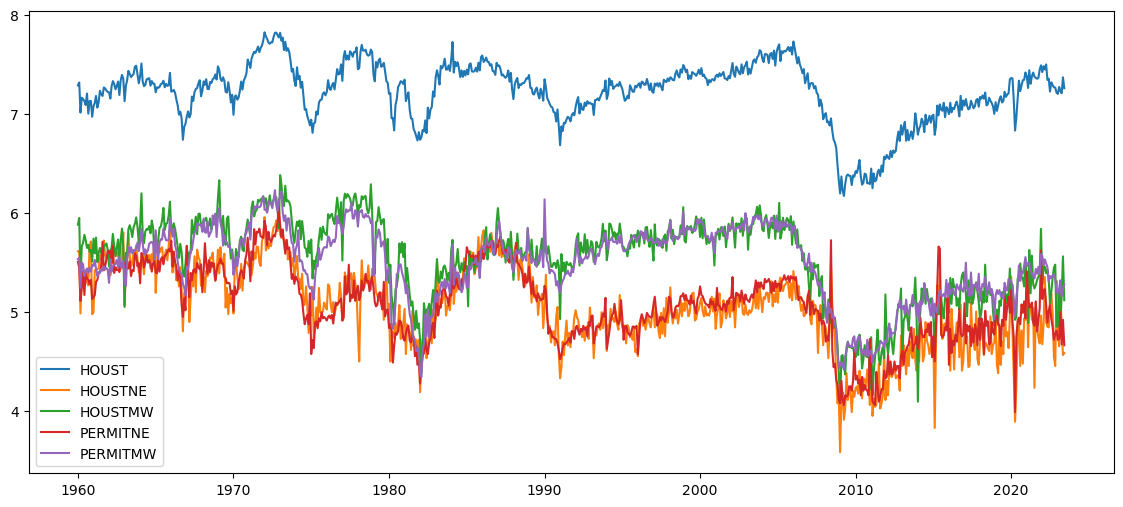

In [9]:
potentially_non_stationary = []

for c in data.columns:
    pvalue = adfuller(data[c])[1] 
    if pvalue > 0.05:
        print(c, pvalue)
        potentially_non_stationary.append(c)


fig, ax = plt.subplots()

for c in potentially_non_stationary:
    ax.plot(data[c], label = c)

ax.legend()
plt.show()

We use the data up to January 1993 for training, and later data for validation. For the purposes of standardisation, we use compute means and stds for the entire sample up to 1993, and after that change them as new observations arrive. # 93 - 23; 93 - 03, 03 - 13, 13 - 23  

In [10]:
def dynamic_normalization(df, cutoff_date = '1993-01-01'):
  
    num_cutoff = df.index.get_loc(cutoff_date)
    df_before = df[:num_cutoff]

    means_before = df_before.mean()
    stds_before = df_before.std()
    
    normalized = (df_before - means_before) / stds_before

    for i in range(num_cutoff, len(df)):
        new_obs = (df[:i] - df[:i].mean()) / df[:i].std()
        last_data_point = pd.DataFrame(new_obs.iloc[-1]).T
        normalized = pd.concat([normalized, last_data_point])

    return normalized
    
    #return normalized_df

In [11]:
data_normalised = dynamic_normalization(df = data)

## PCA - exploratory analysis

### Variance included in the first X factors.

In [12]:
n_components = 10
pca_core = PCA(n_components = n_components)
principal_components = pd.DataFrame(pca_core.fit_transform(data_normalised), index = data_normalised.index)
print(f'The explained variance ratio is: {pca_core.explained_variance_ratio_.round(3)}')
print(f'Sum of explained variance: {pca_core.explained_variance_ratio_.sum().round(3)}')

The explained variance ratio is: [0.201 0.078 0.063 0.042 0.037 0.035 0.03  0.027 0.025 0.024]
Sum of explained variance: 0.562


### Dynamics of loadings in time

In [13]:
collect_explained_variance = {}

for i in range(100, len(data_normalised)):
    pca = PCA(n_components = n_components)

    data_for_pca = data_normalised[:i+1]

    pca.fit(data_for_pca)
    collect_explained_variance[data_for_pca.index[-1]] = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame(collect_explained_variance).T
cumsum_explained_variance_df = explained_variance_df.cumsum(axis = 1)

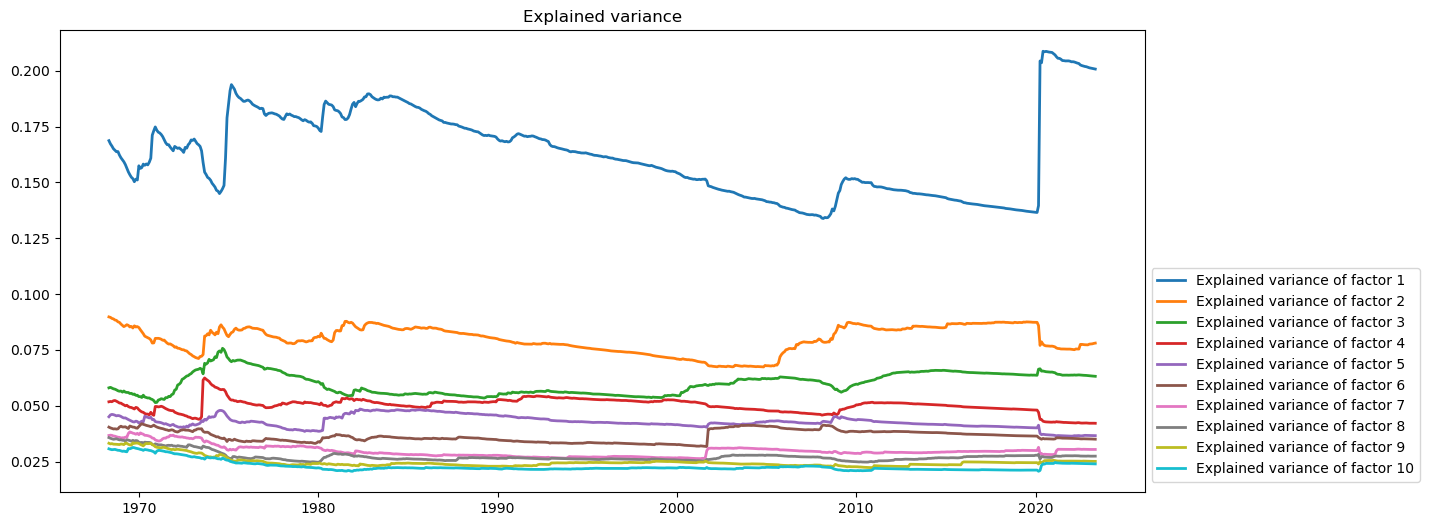

In [14]:
fix, ax = plt.subplots()

plt.title("Explained variance")

for i in range(cumsum_explained_variance_df.shape[1]):
    #ax.plot(cumsum_explained_variance_df.iloc[:, i], label = f"Sum of explained variance up til factor {i+1}", linewidth = 2)
    ax.plot(explained_variance_df.iloc[:, i], label = f"Explained variance of factor {i+1}", linewidth = 2)
    

plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5))
plt.show()

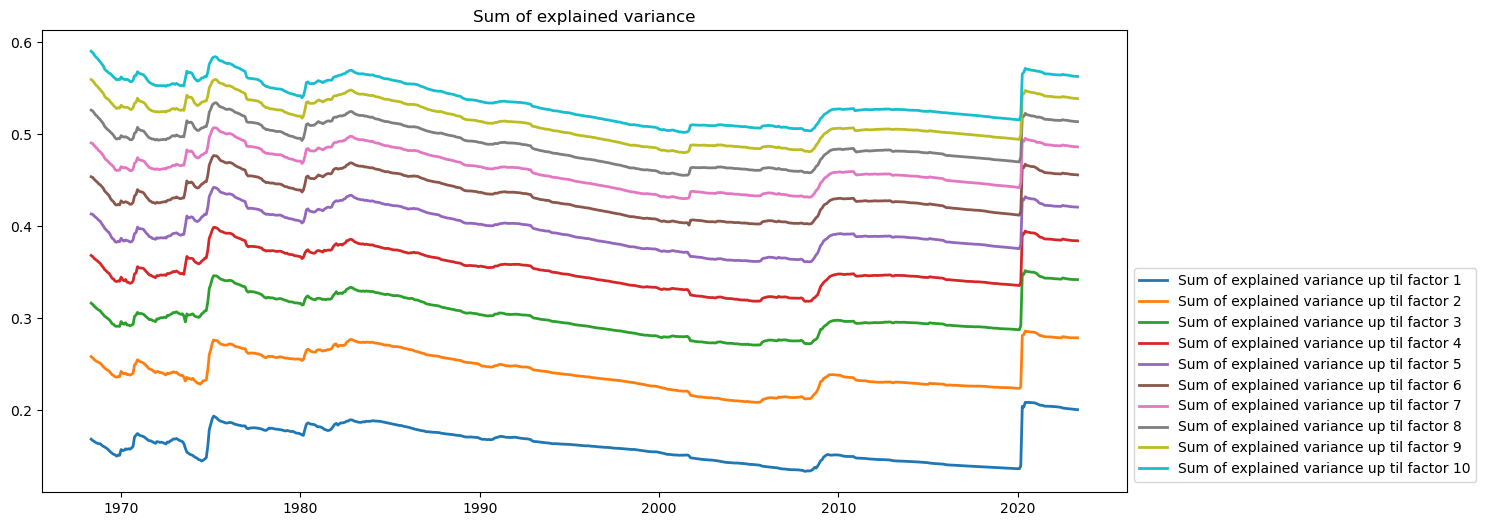

In [15]:
fix, ax = plt.subplots()

plt.title("Sum of explained variance")

for i in range(cumsum_explained_variance_df.shape[1]):
    ax.plot(cumsum_explained_variance_df.iloc[:, i], label = f"Sum of explained variance up til factor {i+1}", linewidth = 2)
    

plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5))
plt.show()

Noticable: 
- Factors are quite stable, except for periods of increased uncertaintly (Covid-19, GFK, 70s);
- Half of the variance is consistently explained by less than 10 factors.

In [16]:
explanatory_power = {}

for i in data_normalised.columns:
    explanatory_power_for_each_input = {}
    for ii in range(principal_components.shape[1]):
        X = principal_components.iloc[:, :(ii + 1)].to_numpy()
        y = data_normalised[i].to_numpy()
        reg = LinearRegression().fit(X, y)
        explanatory_power_for_each_input[ii] = reg.score(X, y)
    
    explanatory_power[i] = explanatory_power_for_each_input 

In [17]:
explanatory_power_df = pd.DataFrame(explanatory_power)
incremental_explanatory_power = explanatory_power_df.copy()

for i in range(explanatory_power_df.shape[0] - 1, 0, -1):
    incremental_explanatory_power.iloc[i, :] = explanatory_power_df.iloc[i, :] - explanatory_power_df.iloc[i-1, :]
explanatory_power_df

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
0,0.009709,0.246456,0.421205,0.447573,0.352732,0.754022,0.749543,0.683225,0.522492,0.567109,...,0.013347,0.005355,0.005678,0.005707,0.001928,0.000126,0.000042,0.000040,0.000961,0.001677
1,0.067071,0.292930,0.429665,0.447585,0.400127,0.763262,0.751132,0.684406,0.522627,0.567180,...,0.626594,0.035192,0.684571,0.043993,0.002154,0.002081,0.001086,0.000864,0.002346,0.003352
2,0.071249,0.302334,0.477795,0.482281,0.416337,0.794810,0.783348,0.729034,0.582948,0.649897,...,0.675249,0.035199,0.760544,0.044187,0.002718,0.002085,0.001272,0.001165,0.002361,0.003736
3,0.221804,0.347315,0.513376,0.517052,0.438918,0.799068,0.791774,0.736275,0.601011,0.664194,...,0.676106,0.035258,0.761762,0.044211,0.006628,0.002312,0.004698,0.008354,0.012391,0.003774
4,0.389136,0.369942,0.549743,0.523903,0.464537,0.830285,0.805660,0.746679,0.614455,0.668688,...,0.679836,0.046924,0.810232,0.066724,0.006900,0.003331,0.013522,0.014467,0.012444,0.007042
5,0.458007,0.372209,0.555548,0.528739,0.477311,0.845999,0.816306,0.758656,0.634305,0.671884,...,0.702298,0.052931,0.811188,0.098539,0.007448,0.005525,0.013558,0.036353,0.013303,0.020051
6,0.729015,0.468625,0.560214,0.530877,0.488644,0.850301,0.822267,0.765732,0.637666,0.677057,...,0.702499,0.055702,0.816776,0.109265,0.010649,0.005756,0.014562,0.063715,0.049682,0.034108
7,0.763686,0.474785,0.577025,0.535074,0.505717,0.855598,0.836730,0.785963,0.689928,0.715426,...,0.717320,0.055706,0.820230,0.126597,0.013031,0.007187,0.017548,0.079584,0.091515,0.039042
8,0.768790,0.481159,0.584790,0.535809,0.518798,0.875253,0.851388,0.801944,0.727072,0.727383,...,0.721616,0.056678,0.841175,0.132235,0.016479,0.016369,0.017838,0.081345,0.104550,0.058897
9,0.779462,0.481178,0.590011,0.539348,0.518870,0.914662,0.902917,0.872125,0.784723,0.741393,...,0.722866,0.056905,0.844260,0.151295,0.019049,0.019125,0.023777,0.092599,0.112071,0.075800


In [18]:
incremental_explanatory_power.mean(axis = 1)

0    0.183770
1    0.072833
2    0.064301
3    0.048305
4    0.040942
5    0.028382
6    0.033860
7    0.025848
8    0.026066
9    0.021436
dtype: float64

In [19]:
incremental_explanatory_power.index = [f"PC {i+1}" for i in range(n_components)]
incremental_explanatory_power.T.sort_values("PC 1", ascending=False)["PC 1"][:10]

PAYEMS       0.853176
IPMANSICS    0.796411
USGOOD       0.785996
INDPRO       0.754022
IPFPNSS      0.749543
MANEMP       0.740278
CUMFNS       0.736141
SRVPRD       0.713983
USTPU        0.702227
DMANEMP      0.692374
Name: PC 1, dtype: float64

In [20]:
incremental_explanatory_power.T.sort_values("PC 2", ascending=False)["PC 2"][:10]

CUSR0000SAC        0.714165
CUSR0000SA0L2      0.698745
DNDGRG3M086SBEA    0.678892
CPIAUCSL           0.674383
CUSR0000SA0L5      0.647175
PCEPI              0.613246
CPITRNSL           0.596821
CPIULFSL           0.562945
WPSFD49502         0.529144
WPSFD49207         0.506898
Name: PC 2, dtype: float64

In [21]:
incremental_explanatory_power.T.sort_values("PC 3", ascending=False)["PC 3"][:10]

HOUST       0.644036
PERMIT      0.613019
PERMITW     0.570538
HOUSTW      0.565755
HOUSTS      0.538933
PERMITMW    0.476196
HOUSTMW     0.435060
PERMITNE    0.398632
PERMITS     0.393038
HOUSTNE     0.335831
Name: PC 3, dtype: float64

In [22]:
incremental_explanatory_power.T.sort_values("PC 4", ascending=False)["PC 4"][:10]

S&P div yield    0.325395
S&P PE ratio     0.293771
S&P 500          0.273028
S&P: indust      0.267272
BAA              0.241795
T5YFFM           0.229130
AAAFFM           0.224855
T10YFFM          0.221279
BAAFFM           0.219110
M2REAL           0.189598
Name: PC 4, dtype: float64

In [23]:
incremental_explanatory_power.T.sort_values("PC 5", ascending=False)["PC 5"][:10]

GS1         0.199230
CP3Mx       0.178297
TB6MS       0.178040
GS5         0.172590
RPI         0.167332
AAA         0.165050
TB6SMFFM    0.164746
BAA         0.162165
TB3SMFFM    0.160451
T1YFFM      0.155569
Name: PC 5, dtype: float64

In [24]:
incremental_explanatory_power.T.sort_values("PC 6", ascending=False)["PC 6"][:10]

M1SL         0.393774
M2SL         0.263747
TOTRESNS     0.217324
NONBORRES    0.151665
TB6MS        0.145066
TB3MS        0.143812
GS1          0.142856
GS5          0.141068
GS10         0.120616
CONSPI       0.098716
Name: PC 6, dtype: float64

The results are similar to what has been shown in https://s3.amazonaws.com/real.stlouisfed.org/wp/2015/2015-012.pdf both in terms of groups identified based on factor loadings approximated using incremental change in the coefficient of determination as more factors are added and in terms of the average loadings of factors. Important to note that this approach ignores lead-lag structure within the data corresponding to the same area of economic activity, i.e. leading, coincident and lagging indicators are most probably explained by different factors in such decomposition. To overcome such limitation we might be more interested in using only leading and/or coincident indicators and extract principal components from them in order to have a better overview of underlying forces within leading economic signals.

## Pipeline 

For model training and validation we have the following pipeline:
- We skip initial n years of data (baseline = 5 years) for applying standardization and other transformations;
- We treat the last k years of data as our test subset (depending on the number of months ahead forecasting the actual value changes, but in all scenarios we treat data starting at least from 2011 as test subset);
- Within the remaining data, we create subsets of l + m months (l = 360, m = 60 in baseline scenario) as training and testing subsets and slide over the data with a step of 12 months to generate multiple instances of training/testing subsets. As a result we train out model always on l months of data and evaluate its performance on m months of data. Though we have overlaps between the different train/test subsets (as a step of 12 months is less than m), this helps us facilitate multiple folds and keep the folds equal weighted for the final evaluation (since in all cases we have the same number of samples for training and evaluation).

The design of our tests is to evaluate a selection of models while changing:
- forecast horizon (1, 3, 6, 12, 24)
- lags included:  [1], [1..3], [1..6], [12], [12, 24], [12, 24, 36], [12, 24, 36, 48], [12, 24, 36, 48], [12, 24, 36, 48, 60]
- applying standardization vs. not applying it
- extracting principal components or not
- converting to a classification problem (US recessions)

In [25]:
class Pipeline:

    def __init__(self, 
                 df,
                 y_name,
                 model,
                 autoregressive_lags, 
                 lags, 
                 h_ahead, 
                 start_rolling_std="1965-01-01", 
                 standardize=True,
                 use_pca=False, 
                 num_components=20, 
                 latest_start_test="2003-07-01", 
                 size_train=360, 
                 size_val=60, 
                 step=12,
                 metric=mean_absolute_error,
                 one_val_fold=False):
        
        """
        df: pd.Dataframe with X and y
        y_name: str, column name of the target variable
        autoregressive_lags: list with the lags of the target variable
        lags: list with lags (as integers)
        h_ahead: int (how many month ahead do we make a forecast)
        start_rolling_std: str, date until which the data is used to kick start the transformations for standardization and PCA
        standardize: boolean
        use_pca: boolean 
        num_components: int, the number of components to extract during PCA 
        """

        self.data = df.copy()
        self.y_name = y_name
        self.model = model
        self.autoregressive_lags = autoregressive_lags 
        self.lags = lags 
        self.h_ahead = h_ahead
        self.start_rolling_std = start_rolling_std
        self.standardize = standardize
        self.use_pca = use_pca
        self.num_components = num_components

        self.latest_start_test = latest_start_test
        self.size_train = size_train
        self.size_val = size_val
        self.step = step
        self.one_val_fold = one_val_fold

        self.metric = metric


    def prepare_data(self):
        
        y = self.data[self.y_name].copy()
        del self.data[self.y_name]

        iloc_start_rolling_std = self.data.index.get_loc(self.start_rolling_std)

        if self.standardize:
        
            scaler = StandardScaler()
            X_normalized = pd.DataFrame(scaler.fit_transform(self.data.iloc[:iloc_start_rolling_std]), index=self.data.index[:iloc_start_rolling_std], columns=self.data.columns)

            if self.use_pca:
                pca = PCA(n_components=self.num_components)
                pca.fit(X_normalized) 
                X_normalized = pd.DataFrame(pca.transform(X_normalized), index=self.data.index[:iloc_start_rolling_std], columns=[f"{i} PC" for i in range(self.num_components)])

            for i in range(iloc_start_rolling_std+1, len(self.data)+1):
                X_normalized_new = pd.DataFrame(scaler.fit_transform(self.data.iloc[:i]), index=self.data.index[:i], columns=self.data.columns)
            
                if self.use_pca:
                    X_normalized_new = pd.DataFrame(pca.transform(X_normalized_new), index=self.data.index[:i], columns=[f"{i} PC" for i in range(self.num_components)])

                X_normalized = pd.concat([X_normalized.T, X_normalized_new.iloc[-1]], axis=1).T
    
        else:
            X_normalized = self.data

        if self.standardize:

            scaler_y = StandardScaler()
            y_normalized = scaler_y.fit_transform(y.iloc[:iloc_start_rolling_std].to_numpy().reshape(-1,1))

            for i in range(iloc_start_rolling_std+1, len(self.data)+1):
                y_normalized_new = scaler_y.fit_transform(y.iloc[:i].to_numpy().reshape(-1,1))
                y_normalized = np.append(y_normalized, y_normalized_new[-1])
            
            y_normalized_s = pd.Series(y_normalized, index=y.index)
    
        else:
            y_normalized_s = y

        for c in X_normalized.columns:
            for l in self.lags:
                name = f"{c}, {l}-month lag"
                new = X_normalized[c].shift(l)
                new.name = name
            
                X_normalized = pd.concat([X_normalized, new], axis=1)

        for l in self.autoregressive_lags:
            name = f"{self.y_name}, {l}-month lag"
            new = y_normalized_s.shift(l)
            new.name = name
            X_normalized = pd.concat([X_normalized, new], axis=1)

        y_shifted = y.shift(-self.h_ahead)

        if len(self.lags) > 0:
            y = y_shifted.iloc[max(self.lags):-self.h_ahead]
            X = X_normalized.iloc[max(self.lags):-self.h_ahead]

        else:
            y = y_shifted.iloc[:-self.h_ahead]
            X = X_normalized.iloc[:-self.h_ahead]

        assert (y.index == X.index).all()
        
        self.y = y
        self.X = X
        self.skip = iloc_start_rolling_std


    def generate_train_val_samples(self):

        train_val = []

        iloc_start_test = self.y.index.get_loc(self.latest_start_test)

        rw_errors = []

        if self.one_val_fold:
            self.size_train = len(self.y) - self.skip - (len(self.y) - iloc_start_test) - self.size_val

            train_val.append((self.y.iloc[(self.skip):(self.skip+self.size_train)], self.X.iloc[(self.skip):(self.skip+self.size_train)], self.y.iloc[(self.skip+self.size_train):iloc_start_test], self.X.iloc[(self.skip+self.size_train):iloc_start_test]))
            rw_errors.append(self.metric(y_pred=self.y.iloc[(self.skip+self.size_train - self.h_ahead):(iloc_start_test - self.h_ahead)], y_true=self.y.iloc[(self.skip+self.size_train):iloc_start_test]))

        else:
            for i in range(self.skip + self.size_train + self.size_val, iloc_start_test, self.step):

                train_val.append((self.y.iloc[(i - self.size_train - self.size_val):(i - self.size_val)], self.X.iloc[(i - self.size_train - self.size_val):(i - self.size_val)], self.y.iloc[(i - self.size_val):i], self.X.iloc[(i - self.size_val):i]))
                rw_errors.append(self.metric(y_pred=self.y.iloc[(i - self.size_val - self.h_ahead):(i - self.h_ahead)], y_true=self.y.iloc[(i - self.size_val):i]))
        
        self.full_train_sample = (self.y.iloc[:iloc_start_test], self.X.iloc[:iloc_start_test])
        self.test_sample = (self.y.iloc[iloc_start_test:], self.X.iloc[iloc_start_test:])
        self.test_rw_prediction = self.y.shift(self.h_ahead).iloc[iloc_start_test:]
        self.train_val = train_val
        self.rw_errors = rw_errors
        
    
    def train_validate_model(self):

        errors = []

        for y_train, X_train, y_test, X_test in self.train_val:
            
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.metric(y_pred=prediction, y_true=y_test)
            errors.append(error)

        self.errors = errors

    def test_model(self):

        self.model.fit(X=self.full_train_sample[1], y=self.full_train_sample[0])
        self.prediction = pd.Series(self.model.predict(self.test_sample[1]), index=self.test_sample[0].index)
        self.test_error = self.metric(y_pred=self.prediction, y_true=self.test_sample[0])

## Identification of a problem

In [26]:
def has_consecutive_negatives(window):
    return int((window < 0).sum() >= 6)

consecutive_negative_growth_before = data["INDPRO"].rolling(window=6).apply(has_consecutive_negatives, raw=True).fillna(0)
consecutive_negative_growth_after = data["INDPRO"][::-1].rolling(window=6).apply(has_consecutive_negatives, raw=True).fillna(0)[::-1]

def func(series):
    return series > 0

technical_recession = (consecutive_negative_growth_before + consecutive_negative_growth_after).apply(func)

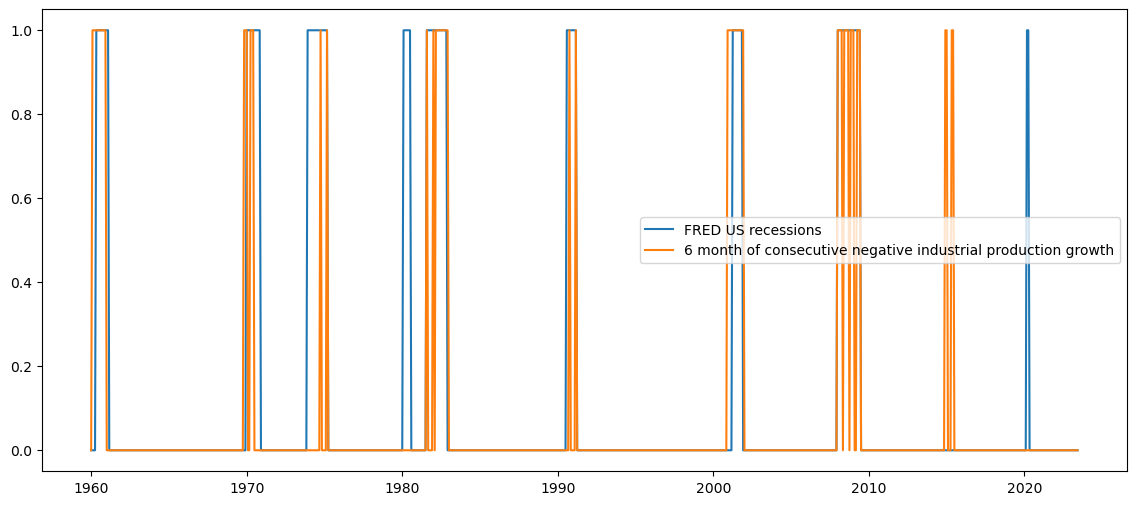

In [27]:
fix, ax = plt.subplots()

ax.plot(us_recession, label="FRED US recessions")
ax.plot(technical_recession, label="6 month of consecutive negative industrial production growth")

plt.legend(loc="best")
plt.show()

In [28]:
indpro_yoy = np.log(df["INDPRO"].iloc[1:]).diff(12) * 100
indpro_yoy.index = df["sasdate"][1:]
indpro_yoy.index = pd.to_datetime(indpro_yoy.index)

indpro_mom = np.log(df["INDPRO"].iloc[1:]).diff(1) * 100
indpro_mom.index = df["sasdate"][1:]
indpro_mom.index = pd.to_datetime(indpro_mom.index)


regions = []
current_region = None

for i, value in enumerate(us_recession.to_numpy()):
    if value == 1:
        if current_region is None:
            current_region = [i, i]
        else:
            current_region[1] = i
    else:
        if current_region is not None:
            regions.append(current_region)
            current_region = None

if current_region is not None:
    regions.append(current_region)

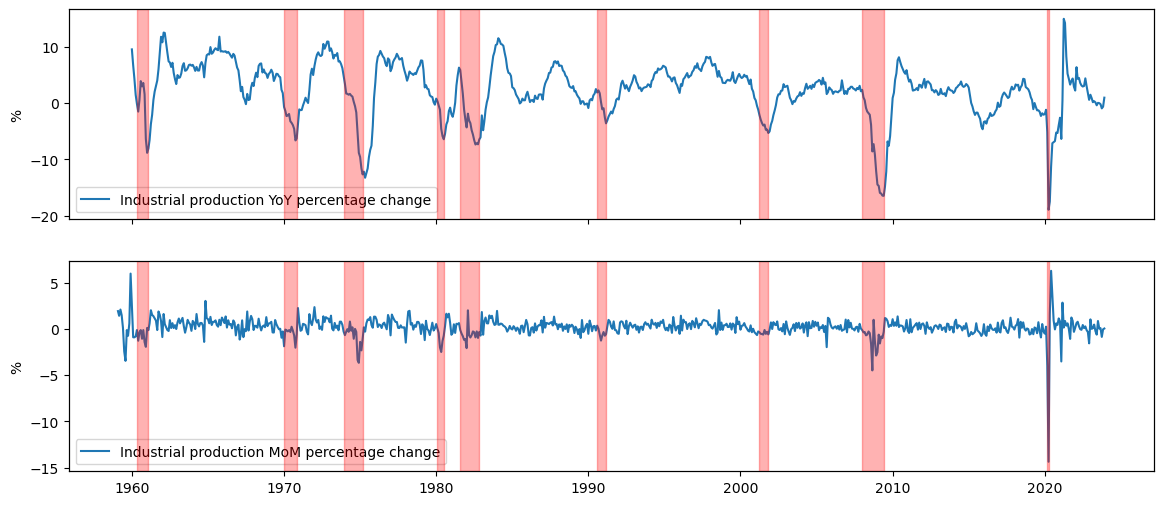

In [29]:
fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(indpro_yoy, label = 'Industrial production YoY percentage change')
axs[0].set_ylabel('%')

ax0_r = axs[0].twinx()
ax0_r.set_ylim(0, 1)
ax0_r.yaxis.set_visible(False)

for start, end in regions:
    if int(us_recession.iloc[start]) == 1:
        ax0_r.axvspan(us_recession.index[start], us_recession.index[end], color='red', alpha=0.3)
    else:
        ax0_r.axvspan(us_recession.index[start], us_recession.index[end], color='blue', alpha=0.3)

axs[1].plot(indpro_mom, label = 'Industrial production MoM percentage change')
axs[1].set_ylabel('%')

ax1_r = axs[1].twinx()
ax1_r.set_ylim(0, 1)
ax1_r.yaxis.set_visible(False)

for start, end in regions:
    if int(us_recession.iloc[start]) == 1:
        ax1_r.axvspan(us_recession.index[start], us_recession.index[end], color='red', alpha=0.3)
    else:
        ax1_r.axvspan(us_recession.index[start], us_recession.index[end], color='blue', alpha=0.3)


axs[0].legend()
axs[1].legend()

plt.show()

In [30]:
data_with_indpro_yoy = data.copy()
data_with_indpro_yoy["INDPRO"] = indpro_yoy
data_with_indpro_yoy["INDPRO"]

data_with_indpro_mom = data.copy()
data_with_indpro_mom["INDPRO"] = data_with_indpro_mom["INDPRO"] * 100

## Regression problem

Regression models:
- Ridge
- Lasso
- LassoLars
- SVR
- RandomForest Regressor
- MLPRegressor
- GradientBoosting Regressor

Baseline scenario:
- Use YoY change in industrial production
- Use only the original data and 1-month lagged data
- 12-month ahead forecast
- Standardized data

In [31]:
h_s = [1, 3, 6, 12, 24]
lags_s = [[1], [1,2,3], [1,2,3,4,5,6], [12], [12, 24], [12, 24, 36], [12, 24, 36, 48], [12, 24, 36, 48], [12, 24, 36, 48, 60]]

### Testing individual models

In [91]:
alphas_ridge_lasso = [10 ** (-5  + (i * 9 / 99)) for i in range(0, 100)]

#### Ridge 

In [97]:
model_ridge = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=Ridge(alpha=alphas_ridge_lasso[0]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_ridge.prepare_data()
model_ridge.generate_train_val_samples()

mae_ridge = {}

for a in alphas_ridge_lasso:

    model_ridge.model = Ridge(alpha=a)
    model_ridge.train_validate_model()
    mae_ridge[a] = model_ridge.errors 

mean_mae_ridge = [np.asarray(i).mean() for i in mae_ridge.values()]

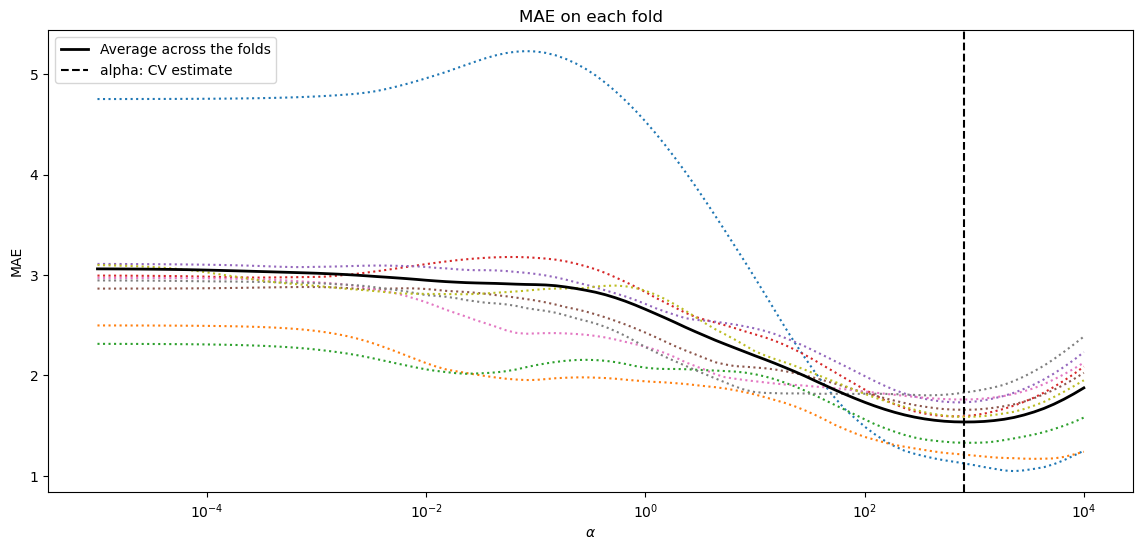

In [106]:
plt.semilogx(alphas_ridge_lasso, mae_ridge.values(), linestyle=":")

plt.plot(alphas_ridge_lasso, mean_mae_ridge,
    color="black", label="Average across the folds", linewidth=2)

plt.axvline(alphas_ridge_lasso[np.argmin(mean_mae_ridge)], linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("MAE")
plt.legend()
plt.title(f"MAE on each fold")
plt.show()

In [107]:
model_ridge = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=Ridge(alpha=alphas_ridge_lasso[np.argmin(mean_mae_ridge)]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_ridge.prepare_data()
model_ridge.generate_train_val_samples()
model_ridge.train_validate_model()
np.mean(model_ridge.errors)

1.5359133072629823

In [108]:
np.mean(model_ridge.rw_errors)

1.6693726963334545

#### Lasso

In [109]:
model_lasso = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=Lasso(alpha=alphas_ridge_lasso[0], max_iter=100000),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_lasso.prepare_data()
model_lasso.generate_train_val_samples()

mae_lasso = {}

for a in alphas_ridge_lasso:

    model_lasso.model = Lasso(alpha=a)
    model_lasso.train_validate_model()
    mae_lasso[a] = model_lasso.errors 

mean_mae_lasso = [np.asarray(i).mean() for i in mae_lasso.values()]

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e+02, tolerance: 7.751e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e+02, tolerance: 7.406e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e+02, tolerance: 7.282e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e+02, tolerance: 7.212e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e+02, tolerance: 7.144e-01
Objective did n

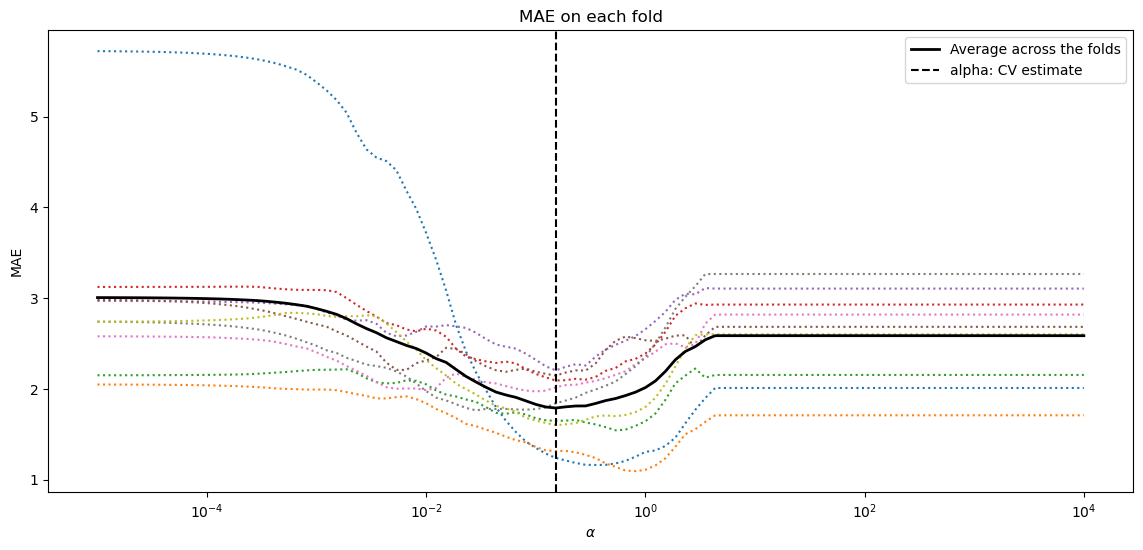

In [110]:
plt.semilogx(alphas_ridge_lasso, mae_lasso.values(), linestyle=":")

plt.plot(alphas_ridge_lasso, mean_mae_lasso,
    color="black", label="Average across the folds", linewidth=2)

plt.axvline(alphas_ridge_lasso[np.argmin(mean_mae_lasso)], linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("MAE")
plt.legend()
plt.title(f"MAE on each fold")
plt.show()

In [111]:
model_lasso = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=Lasso(alpha=alphas_ridge_lasso[np.argmin(mean_mae_lasso)]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 #use_pca=True
                 )
model_lasso.prepare_data()
model_lasso.generate_train_val_samples()
model_lasso.train_validate_model()
np.mean(model_lasso.errors)

1.7893523654666472

In [112]:
np.mean(model_lasso.rw_errors)

1.6693726963334545

#### Lasso LARS

In [113]:
model_lars = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=linear_model.LassoLars(alpha=alphas_ridge_lasso[0]),
                 lags=[],#lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_lars.prepare_data()
model_lars.generate_train_val_samples()

mae_lars = {}

for a in alphas_ridge_lasso:

    model_lars.model = linear_model.LassoLars(alpha=a)
    model_lars.train_validate_model()
    mae_lars[a] = model_lars.errors 

mean_mae_lars= [np.asarray(i).mean() for i in mae_lars.values()]

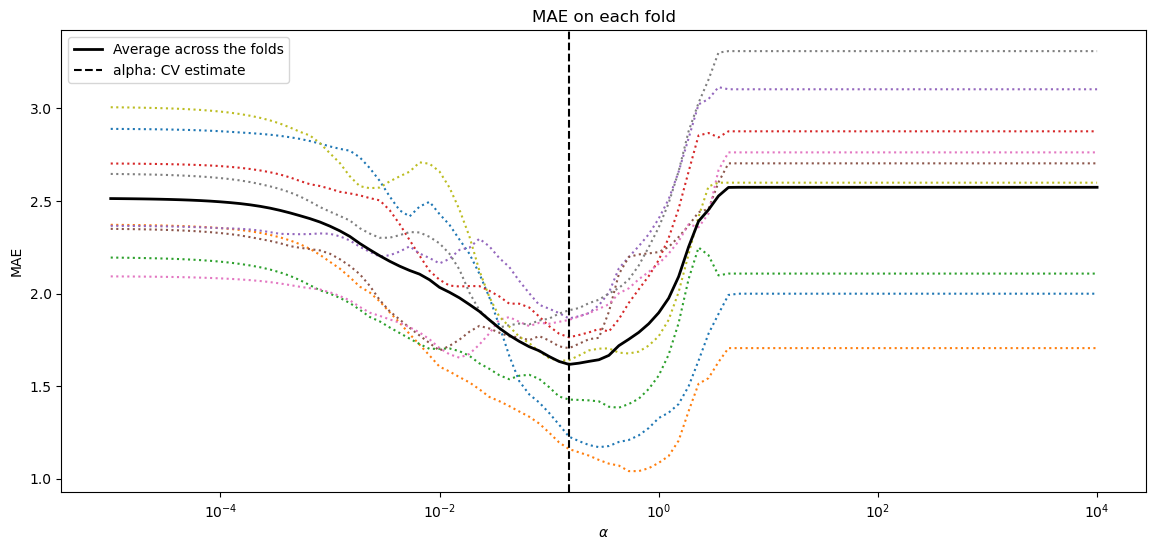

In [114]:
plt.semilogx(alphas_ridge_lasso, mae_lars.values(), linestyle=":")

plt.plot(alphas_ridge_lasso, mean_mae_lars,
    color="black", label="Average across the folds", linewidth=2)

plt.axvline(alphas_ridge_lasso[np.argmin(mean_mae_lars)], linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("MAE")
plt.legend()
plt.title(f"MAE on each fold")
plt.show()

In [115]:
alphas_ridge_lasso[np.argmin(mean_mae_lars)]

0.1519911082952933

In [116]:
alphas_ridge_lasso[np.argmin(mean_mae_lasso)]

0.1519911082952933

#### SVR

In [55]:
C = [2 ** (1  + (i * 4 / 9)) for i in range(0, 10)]
gamma = [2 ** (-7  + (i * 6 / 9)) for i in range(0, 10)]
epsilon = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [121]:
model_svr = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=SVR(C=2, gamma=gamma[0], epsilon=epsilon[0]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_svr.prepare_data()
model_svr.generate_train_val_samples()

mae_svr = {}

for g in gamma:
    for eps in epsilon:

        model_svr.model = SVR(C=2, gamma=g, epsilon=eps)
        model_svr.train_validate_model()
        mae_svr[f"{g},{eps}"] = model_svr.errors 

mean_mae_svr = [np.asarray(i).mean() for i in mae_svr.values()]

In [122]:
mean_mae_svr_dict = {k: np.asarray(v).mean() for (k,v) in mae_svr.items()}

In [123]:
mean_mae_svr_arr = np.zeros((len(gamma), len(epsilon)))

In [124]:
for k,v in mean_mae_svr_dict.items():
    els = [float(i) for i in k.split(',')]
    for ii, g in enumerate(gamma):
        if g == els[0]:
            for iii, e in enumerate(epsilon):
                if e == els[1]:
                    mean_mae_svr_arr[ii, iii] = v

In [125]:
list(mae_svr.keys())[np.argmin(mean_mae_svr)]

'0.0078125,0.5'

In [126]:
np.min(mean_mae_svr)

1.7024147150415248

In [127]:
np.min(mean_mae_svr_arr)

1.7024147150415248

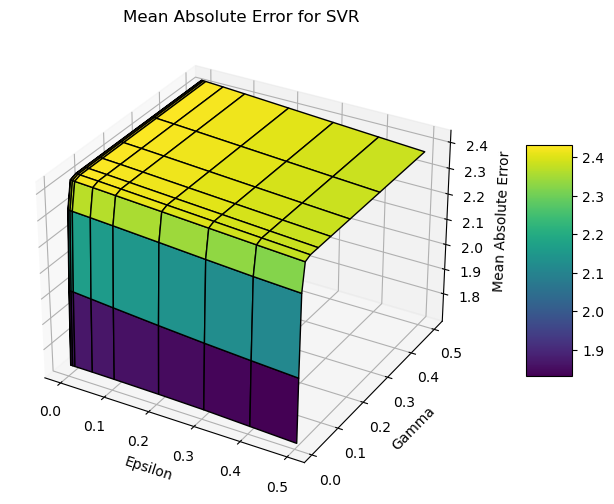

In [128]:
# Plot 3D surface

E, G = np.meshgrid(epsilon, gamma)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(E,G, Z=mean_mae_svr_arr[:,:], cmap='viridis', edgecolor='k')

# Set labels and title
ax.set_xlabel('Epsilon')
ax.set_ylabel('Gamma')
ax.set_zlabel('Mean Absolute Error')
plt.title('Mean Absolute Error for SVR')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#### Random Forest Regressor

In [133]:
max_depth_s = [2, 3, 5, 8, 10, 30]
max_features_s = [3, 5, 7, 11, 30]

In [134]:
model_rf = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=RandomForestRegressor(n_estimators=500, 
                                             criterion="absolute_error"),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_rf.prepare_data()
model_rf.generate_train_val_samples()

mae_rf = {}

count = 0
for i in max_depth_s:
    for ii in max_features_s:
        model_rf.model = RandomForestRegressor(n_estimators=500, 
                                             max_depth=i,
                                             max_features=ii)
        model_rf.train_validate_model()
        mae_rf[f"{i},{ii}"] = model_rf.errors
        count+=1
        if count % 10 == 0:
            print(count)


mean_mae_rf = [np.asarray(i).mean() for i in mae_rf.values()]

10
20
30


In [140]:
np.min(mean_mae_rf)

1.68325615848618

In [141]:
list(mae_rf.keys())[np.argmin(mean_mae_rf)]

'10,3'

#### Gradient boosting

In [35]:
subsample = [0.05, .1, .3, .6, .9]
n_estimators = [5, 10, 30, 75]
max_depth = [2, 5, 8, 15]

In [43]:
model_gbr = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=GradientBoostingRegressor(subsample=subsample[0], 
                                     n_estimators=n_estimators[1],
                                     loss='absolute_error', 
                                     max_depth=max_depth[1],
                                     random_state=92834),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True
                 )
model_gbr.prepare_data()
model_gbr.generate_train_val_samples()
model_gbr.train_validate_model()

In [44]:
np.mean(model_gbr.errors)

2.0356732806514954

#### MLP Regressor

In [45]:
solver = "lbfgs"
max_iter = 2000
hidden_layer_sizes = [5, (5,5), (5,5,5), 10, (10,10), (10,10,10), 15,
                      (15, 15), 25, (25, 25), (25, 25, 25)]
activation = ["relu", "tanh"]
alpha = [10 ** i for i in range(-5, 4)]

In [76]:
model_mlp = Pipeline(data_with_indpro_yoy, 
                 y_name=target_variable, 
                 autoregressive_lags=[0] + lags_s[0], 
                 model=MLPRegressor(solver=solver, 
                                    max_iter=max_iter, 
                                    hidden_layer_sizes=hidden_layer_sizes[-1],
                                    activation=activation[0],
                                    alpha=alpha[-4]),
                 lags=lags_s[0], 
                 h_ahead=6,
                 standardize=True,
                 step=12
                 )
model_mlp.prepare_data()
model_mlp.generate_train_val_samples()
model_mlp.size_train

360

In [77]:
model_mlp.train_validate_model()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [78]:
model_mlp.errors

[1.653732491380271, 1.8986192807173192, 2.0079222961328616, 2.2588999468504847]

In [79]:
np.mean(model_mlp.errors)

1.9547935037702342

In [80]:
model_mlp.test_model()

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [83]:
model_mlp.test_error

3.9483129953582266

In [81]:
p = pd.Series(model_mlp.prediction, index=model_mlp.test_sample[0].index)

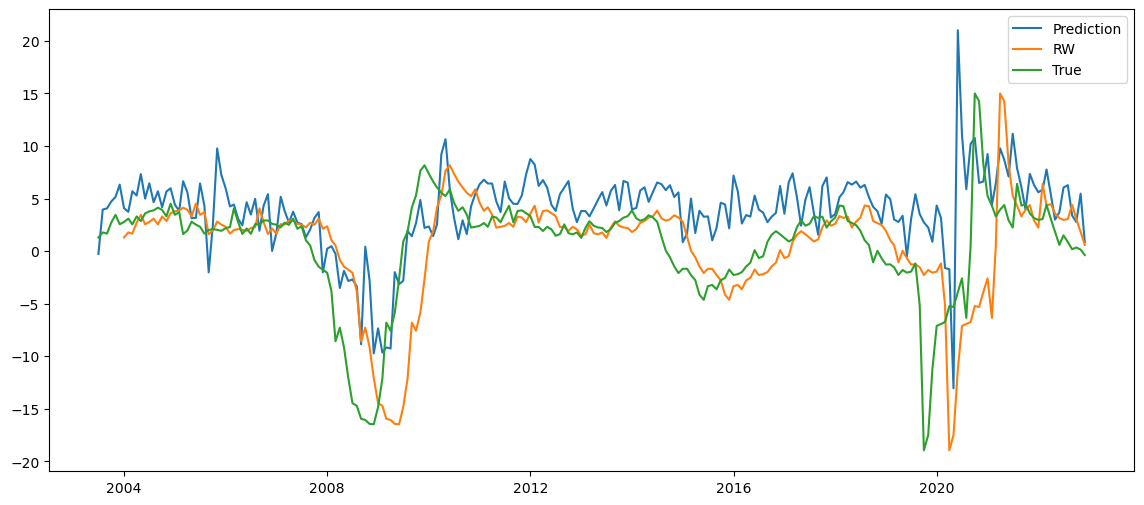

In [82]:
fix, ax = plt.subplots()

ax.plot(p, label="Prediction")
ax.plot(model_mlp.test_sample[0].shift(6), label="RW")
ax.plot(model_mlp.test_sample[0], label="True")

plt.legend(loc="best")
plt.show()

In [578]:
"""
explainer = shap.Explainer(gbr)
shap_values = explainer.shap_values(X_test[7])
shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = X_df.columns
)
"""

'\nexplainer = shap.Explainer(gbr)\nshap_values = explainer.shap_values(X_test[7])\nshap.initjs()\n\nshap.force_plot(\n    base_value = explainer.expected_value,\n    shap_values = shap_values,\n    features = X_df.columns\n)\n'

### Joint testing of the models

In [68]:
def evaluate_models(df=data_with_indpro_yoy,
                 y_name=target_variable,
                 autoregressive_lags=None, 
                 lags=None, 
                 h_ahead=None, 
                 start_rolling_std="1965-01-01", 
                 standardize=True,
                 use_pca=False, 
                 num_components=10, 
                 latest_start_test="2003-07-01", 
                 size_train=360, 
                 size_val=60, 
                 step=12,
                 random_state=98234):
    
    pipeline = Pipeline(df=df,
                 y_name=y_name,
                 autoregressive_lags=autoregressive_lags, 
                 model=None,
                 lags=lags, 
                 h_ahead=h_ahead, 
                 start_rolling_std=start_rolling_std, 
                 standardize=standardize,
                 use_pca=use_pca, 
                 num_components=num_components, 
                 latest_start_test=latest_start_test, 
                 size_train=size_train, 
                 size_val=size_val, 
                 step=step)
    
    
    
    pipeline.prepare_data()
    pipeline.generate_train_val_samples()

    
    print("Ridge")
    print("-"*50)

    alphas_ridge = [10 ** (-5  + (i * 9 / 99)) for i in range(0, 100)]

    mae_ridge = {}
    for a in alphas_ridge:
        pipeline.model = Ridge(alpha=a, random_state=random_state) 
        pipeline.train_validate_model()
        mae_ridge[a] = pipeline.errors 

    mean_mae_ridge = [np.asarray(i).mean() for i in mae_ridge.values()]
    
    pipeline.model = Ridge(alpha=alphas_ridge[np.argmin(mean_mae_ridge)], random_state=random_state)
    pipeline.test_model()

    print(f"Ridge: {np.round(pipeline.test_error, 2)}")
    print(f"Alpha: {alphas_ridge[np.argmin(mean_mae_ridge)]}")
    print("-"*50)
    ridge_summary = [mae_ridge, mean_mae_ridge, pipeline.prediction]


    print("LassoLARS")
    print("-"*50)

    alphas_lasso = [10 ** (-5  + (i * 9 / 99)) for i in range(0, 100)]

    mae_lasso = {}
    for a in alphas_lasso:
        pipeline.model = linear_model.LassoLars(alpha=a, random_state=random_state)
        pipeline.train_validate_model()
        mae_lasso[a] = pipeline.errors 

    mean_mae_lasso = [np.asarray(i).mean() for i in mae_lasso.values()]
    
    pipeline.model = linear_model.LassoLars(alpha=alphas_lasso[np.argmin(mean_mae_lasso)], random_state=random_state)
    pipeline.test_model()

    print(f"LassoLARS: {np.round(pipeline.test_error, 2)}")
    print(f"Alpha: {alphas_lasso[np.argmin(mean_mae_lasso)]}")
    print("-"*50)
    lasso_summary = [mae_lasso, mean_mae_lasso, pipeline.prediction]

    
    print("SVR")
    print("-"*50)

    C = [2 ** (1  + (i * 4 / 9)) for i in range(0, 10, 2)]
    gamma = [2 ** (-7  + (i * 6 / 9)) for i in range(0, 10, 2)]
    epsilon = [0.0001, 0.01, 0.05, 0.1, 0.3, 0.5]

    mae_svr = {}
    for c in C:
        for g in gamma:
            for eps in epsilon:
                pipeline.model = SVR(C=c, gamma=g, epsilon=eps)
                pipeline.train_validate_model()
                mae_svr[f"{c}, {g}, {eps}"] = pipeline.errors 

    mean_mae_svr = [np.asarray(i).mean() for i in mae_svr.values()]

    c, g, eps = (float(i) for i in list(mae_svr.keys())[np.argmin(mean_mae_svr)].split(","))
    
    pipeline.model = SVR(C=c, gamma=g, epsilon=eps)
    pipeline.test_model()

    print(f"SVR: {np.round(pipeline.test_error, 2)}")
    print(f"C: {c}, G: {g}, eps: {eps}")
    print("-"*50)
    svr_summary = [mae_svr, mean_mae_svr, pipeline.prediction]

    
    print("RandomForestRegressor")
    print("-"*50)

    max_depth_rf = [2, 3, 5, 8, 10, 30, 50]
    max_features_s = [3, 5, 7, 11, 30, 50]

    mae_rf = {}
    for max_d in max_depth_rf:
        for max_f in max_features_s:
            pipeline.model = RandomForestRegressor(n_estimators=500, 
                                                   max_depth=max_d,
                                                   max_features=max_f,
                                                   random_state=random_state)
            pipeline.train_validate_model()
            mae_rf[f"{max_d}, {max_f}"] = pipeline.errors 

    mean_mae_rf = [np.asarray(i).mean() for i in mae_rf.values()]

    max_d, max_f = (int(i) for i in list(mae_rf.keys())[np.argmin(mean_mae_rf)].split(","))
    
    pipeline.model = RandomForestRegressor(n_estimators=500, 
                                           max_depth=max_d,
                                           max_features=max_f,
                                           random_state=random_state)
    pipeline.test_model()

    print(f"RandomForestRegressor: {np.round(pipeline.test_error, 2)}")
    print(f"Max depth: {max_d}, Max features: {max_f}")
    print("-"*50)
    rf_summary = [mae_rf, mean_mae_rf, pipeline.prediction]

    
    print("GradientBoostingRegressor")
    print("-"*50)

    subsample = [0.05, .1, .3, .6, .9]
    n_estimators = [5, 10, 30, 75, 150]
    max_depth_gb = [2, 5, 8, 15]

    mae_gbr = {}
    for subs in subsample:
        for n_est in n_estimators:
            for md_gb in max_depth_gb:
                pipeline.model = GradientBoostingRegressor(subsample=subs, 
                                     n_estimators=n_est,
                                     loss='absolute_error', 
                                     max_depth=md_gb,
                                     random_state=random_state)
                pipeline.train_validate_model()
                mae_gbr[f"{subs}, {n_est}, {md_gb}"] = pipeline.errors 

    mean_mae_gbr = [np.asarray(i).mean() for i in mae_gbr.values()]

    params_gbr = list(mae_gbr.keys())[np.argmin(mean_mae_gbr)].split(",")
    subs, n_est, md_gb = float(params_gbr[0]), int(params_gbr[1]), int(params_gbr[2])
    
    pipeline.model = GradientBoostingRegressor(subsample=subs, 
                                     n_estimators=n_est,
                                     loss='absolute_error', 
                                     max_depth=md_gb,
                                     random_state=random_state)
    pipeline.test_model()

    print(f"GradientBoostingRegressor: {np.round(pipeline.test_error, 2)}")
    print(f"Subsample: {subs}, n estimators: {n_est}, Max depth: {md_gb}")
    print("-"*50)
    gbr_summary = [mae_gbr, mean_mae_gbr, pipeline.prediction]


    print("MLPRegressor")
    print("-"*50)

    solver = "lbfgs"
    max_iter = 10000
    hidden_layer_sizes = [5, (5,5), 10, (10,10)]
    alpha = [10 ** i for i in range(-5, 4, 2)]

    mae_mlp = {}
    for hl in hidden_layer_sizes:
        for a in alpha:
            pipeline.model = MLPRegressor(solver=solver, 
                                    max_iter=max_iter, 
                                    hidden_layer_sizes=hl,
                                    activation="relu",
                                    alpha=a,
                                    random_state=random_state)
            pipeline.train_validate_model()
            mae_mlp[f"{hl}; {a}"] = pipeline.errors 

    mean_mae_mlp = [np.asarray(i).mean() for i in mae_mlp.values()]

    params_mlp = list(mae_mlp.keys())[np.argmin(mean_mae_mlp)].split(";")
    
    a = float(params_mlp[1])
    if params_mlp[0].startswith("("):
        hl = tuple([int(i) for i in params_mlp[0][1:-1].split(",")])
    else:
        hl = int(params_mlp[0])
    
    pipeline.model = MLPRegressor(solver=solver, 
                                    max_iter=max_iter, 
                                    hidden_layer_sizes=hl,
                                    activation="relu",
                                    alpha=a,
                                    random_state=random_state)
    pipeline.test_model()

    
    print(f"MLPRegressor: {np.round(pipeline.test_error, 2)}")
    print(f"Hidden layer sizes: {hl}, alpha: {a}")
    print("-"*50)
    mlp_summary = [mae_mlp, mean_mae_mlp, pipeline.prediction]

    print(f"RW: {np.round(mean_absolute_error(y_pred=pipeline.test_rw_prediction, y_true=pipeline.test_sample[0]), 2)}")
    print("-"*50)
    
    
    return ridge_summary, lasso_summary, svr_summary, rf_summary, gbr_summary, mlp_summary, pipeline

In [69]:
r, l, svr, rf, gbr, mlp, p = evaluate_models(df=data_with_indpro_yoy,
                       y_name=target_variable, 
                       autoregressive_lags=[0] + lags_s[0], 
                       lags=lags_s[0],
                       h_ahead=6,
                       standardize=True)

Ridge
--------------------------------------------------
Ridge: 3.54
Alpha: 657.9332246575682
--------------------------------------------------
LassoLARS
--------------------------------------------------
LassoLARS: 3.63
Alpha: 0.018738174228603847
--------------------------------------------------
SVR
--------------------------------------------------
SVR: 3.35
C: 12.699208415745595, G: 0.0078125, eps: 0.5
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor: 3.48
Max depth: 10, Max features: 30
--------------------------------------------------
GradientBoostingRegressor
--------------------------------------------------
GradientBoostingRegressor: 3.57
Subsample: 0.3, n estimators: 75, Max depth: 8
--------------------------------------------------
MLPRegressor
--------------------------------------------------
MLPRegressor: 3.43
Hidden layer sizes: 10, alpha: 1000.0
-------------------------

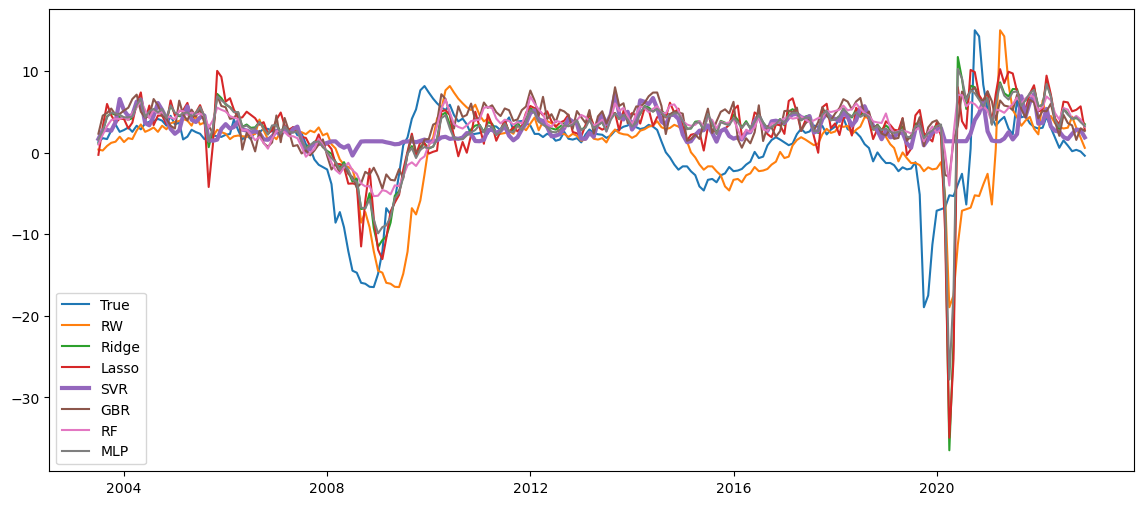

In [72]:
fix, ax = plt.subplots()

ax.plot(p.test_sample[0], label="True")
ax.plot(p.test_rw_prediction, label="RW")
ax.plot(r[2], label="Ridge")
ax.plot(l[2], label="Lasso")
ax.plot(svr[2], label="SVR", linewidth=3)
ax.plot(gbr[2], label="GBR")
ax.plot(rf[2], label="RF")
ax.plot(mlp[2], label="MLP")

plt.legend(loc="best")
plt.show()

## Alternative datasets

In [579]:
df_canada = pd.read_csv("LCDMA_January_2024/TR_CAN_MD.csv")
#df_canada.drop(columns = ['Unnamed: 0'], inplace=True)
df_canada.index = df_canada["Date"]
del df_canada["Date"]
df_canada.head()

,GDP_new,BSI_new,GPI_new,SPI_new,IP_new,NDM_new,DM_new,OILP_new,CON_new,RT_new,...,CPI_MINUS_FOO_BC,CPI_MINUS_FEN_BC,CPI_GOO_BC,CPI_DUR_BC,CPI_SERV_BC,CRED_T_discontinued,CRED_HOUS_discontinued,CRED_MORT_discontinued,CRED_CONS_discontinued,CRE_BUS_discontinued
Date,,,,,,,,,,,,,,,,,,,,,
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [585]:
df_canada_short = df_canada.iloc[df_canada.index.get_loc("1982-02-01"):-1]
df_canada_short.isna().sum(axis = 1)

Date
1982-02-01    33
1982-03-01    33
1982-04-01    33
1982-05-01    33
1982-06-01    33
              ..
2023-07-01     5
2023-08-01     5
2023-09-01     5
2023-10-01     5
2023-11-01     7
Length: 502, dtype: int64

<Axes: xlabel='Date'>

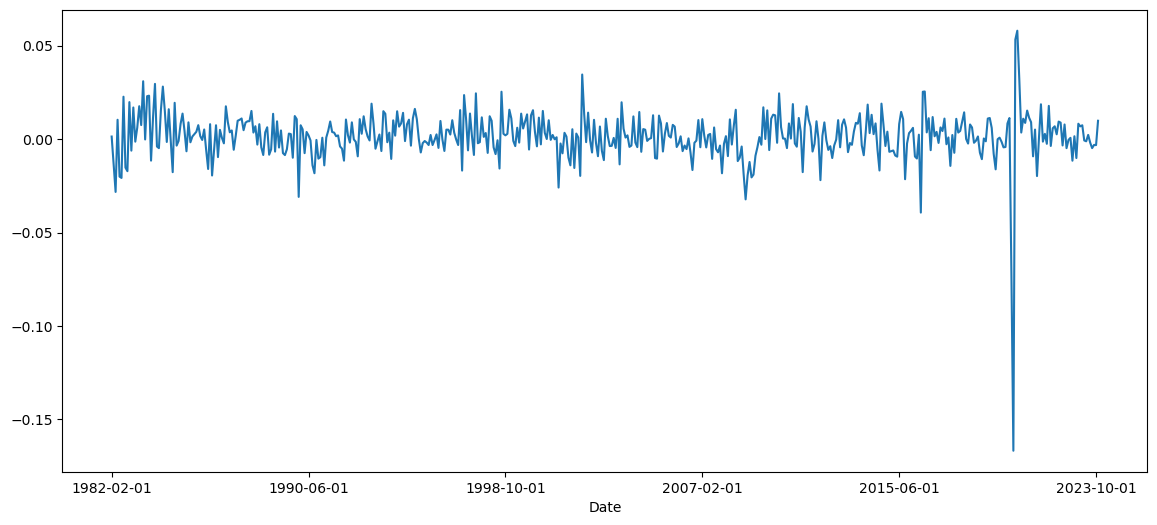

In [588]:
df_canada_short["IP_new"].plot()

In [496]:
df_uk = pd.read_csv("UKMD_January_2024/tr_uk_md.csv")
#df_canada.drop(columns = ['Unnamed: 0'], inplace=True)
df_uk.index = df_uk["Date"]
del df_uk["Date"]
df_uk.head()

,Unnamed: 0,EMP,EMP_PART,EMP_TEMP,UNEMP_RATE,UNEMP_DURA_6mth,UNEMP_DURA_6.12mth,UNEMP_DURA_12mth.,UNEMP_DURA_24mth.,EMP_RATE,...,UK_focused_equity,EUR_UNC_INDEX,BCI,CCI,CLI,PPI_MANU,PPI_MACH,PPI_OIL,PPI_METAL,PPI_MOTOR
Date,,,,,,,,,,,,,,,,,,,,,
1948-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-02-01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-03-01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-04-01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-05-01,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
